In [1]:
import pandas as pd
import numpy as np
from numpy import mean, std, absolute
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import scipy as sp
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import normalize
import shap


plt.style.use('ggplot')

In [2]:
data = pd.read_excel('Data/Gasification Data_Daya.xlsx', index_col=0, header=0)
data = data.iloc[1:223,:14] 
display(list(data.columns.values))

# Drop null balues and store dataframe in dataframe 2
data=data.dropna()
print(data)

#Check Null values again after removing
print(data.isnull().values.any())
print(data.isna().values.any())

X = data.iloc[:, :9]
y = data.iloc[:, 9:]

input_columns = list(X.columns.values)
input_columns = [i.split(' [', 1)[0] for i in input_columns]
output_columns = list(y.columns.values)
output_columns = [i.split(' [', 1)[0] for i in output_columns]
print(input_columns, output_columns)

Xnorm = normalize(X, 'l2', axis=1)
ynorm = normalize(y, 'l2', axis=1)

print(Xnorm.shape, ynorm.shape)

['C [%wt db]',
 'H [%wt db]',
 'O [%wt db]',
 'Moisture [%wt]',
 'Ash [%wt db]',
 'ER [-]',
 'T [ºC]',
 'Bed material',
 'Steam/Biomass',
 'H2 [%vol N2 free]',
 'CO [%vol N2 free]',
 'CO2 [%vol N2 free]',
 'CH4 [%vol N2 free]',
 'GY [Nm3/kg daf]']

        C [%wt db] H [%wt db]  O [%wt db] Moisture [%wt]  Ash [%wt db]  \
Sr No.                                                                   
2            50.00        5.7       44.10             21          0.85   
3            50.00        5.7       44.10             23          0.85   
4            50.00        5.7       44.10             22          0.85   
5            50.00        5.7       44.10             25          0.85   
6            50.00        5.7       44.10             19          0.85   
...            ...        ...         ...            ...           ...   
219          46.85        6.3       45.55              9          1.30   
220          46.85        6.3       45.55              9          1.30   
221          46.76       5.68       39.46           9.94          8.10   
222          46.76       5.68       39.46           9.94          8.10   
223          46.76       5.68       39.46           9.94          8.10   

        ER [-]  T [ºC]  Bed material 

In [30]:
seed = 0
X_train, X_test, y_train, y_test = train_test_split(Xnorm, ynorm, test_size=.3, random_state=seed)

# For Gradient Boost
prediction_gbm = np.zeros_like(y_test) 
gbm = {}
for idx in range(y.shape[1]):
    gbm[idx] = GradientBoostingRegressor(n_estimators=1000, learning_rate=.01, random_state=0, loss='huber')
    gbm[idx].fit(X_train, y_train[:, idx])
    prediction_gbm[:, idx]=gbm[idx].predict(X_test)
error = np.sqrt(mse(y_test, prediction_gbm, multioutput='raw_values'))
r2value = r2(y_test, prediction_gbm, multioutput='raw_values')
print(error, r2value)

[0.11789383 0.05614933 0.06105002 0.03758106 0.00491306] [0.41134198 0.74538523 0.85579858 0.78806116 0.8967092 ]


## Variable Importance Plot--Global Interpretability

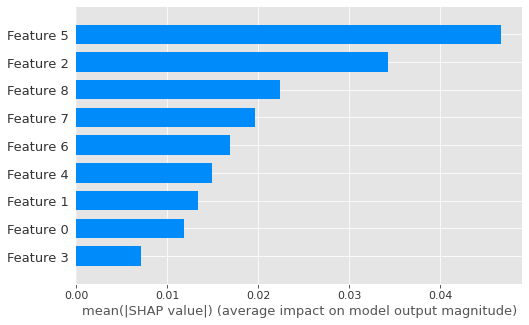

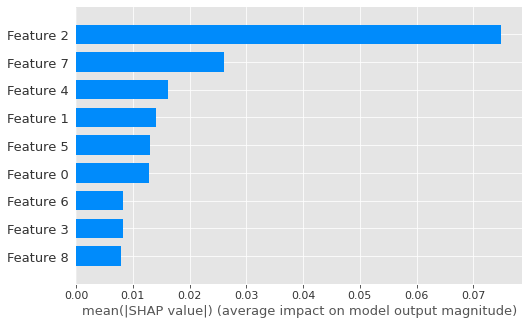

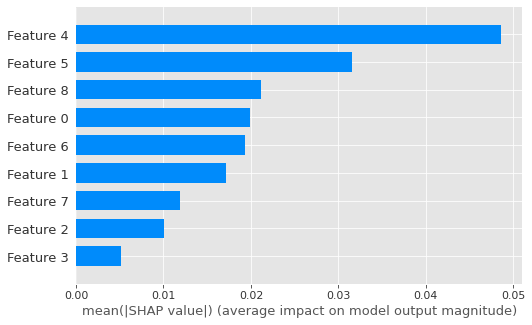

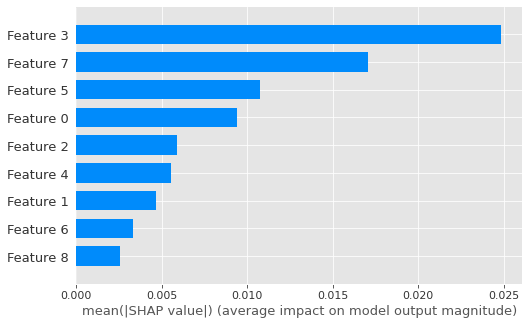

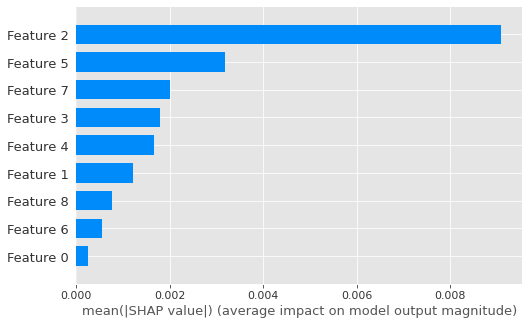

In [6]:
for idx in range(y.shape[1]):
    shap_values = shap.TreeExplainer(gbm[idx]).shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar")

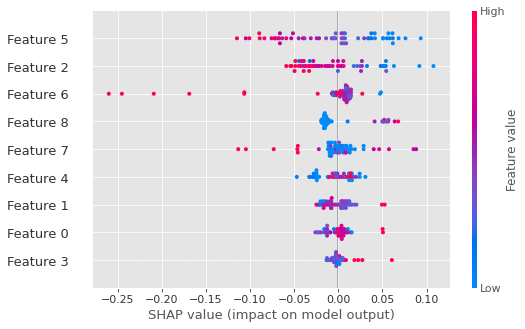

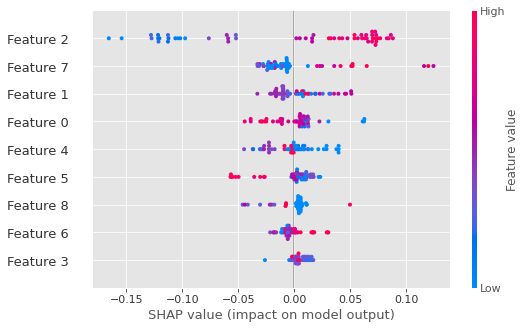

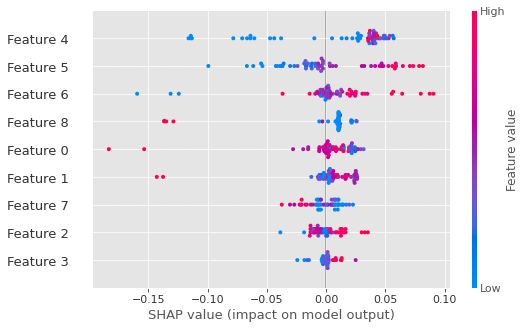

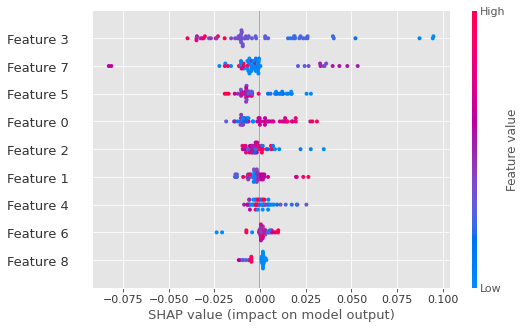

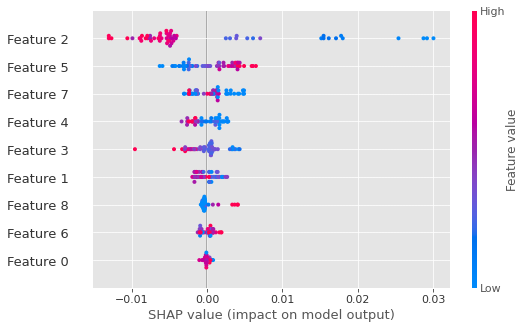

In [8]:
for idx in range(y.shape[1]):
    shap_values = shap.TreeExplainer(gbm[idx]).shap_values(X_test)
    shap.summary_plot(shap_values, X_test)

## SHAP Dependence Plot -- Global Interpretability

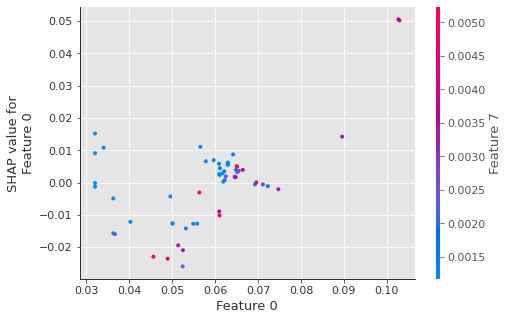

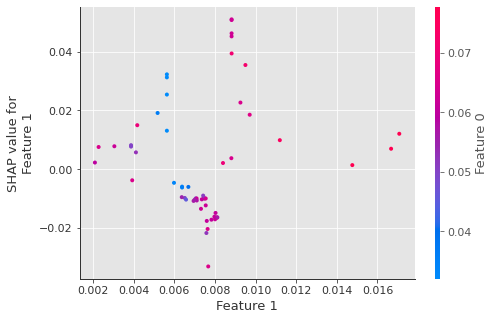

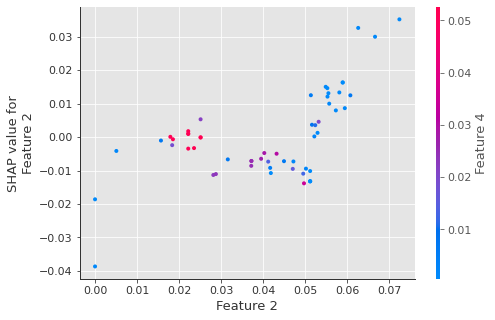

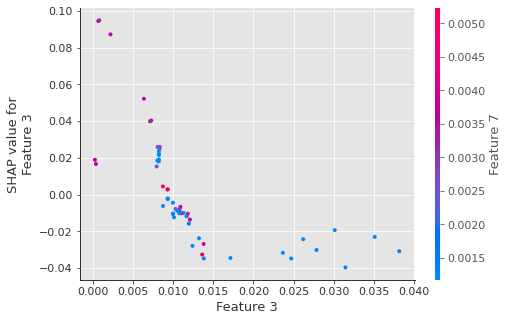

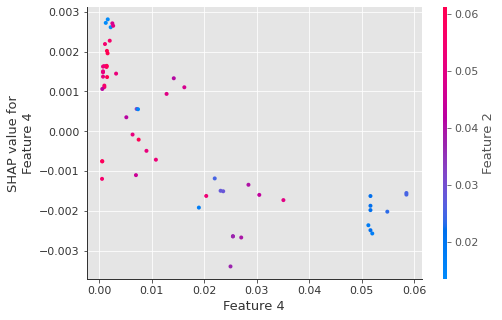

In [11]:
for idx in range(y.shape[1]):
    shap_values = shap.TreeExplainer(gbm[idx]).shap_values(X_test)
    shap.dependence_plot(idx, shap_values, X_test)

## Individual SHAP Value Plot -- Local Interpretability

In [23]:
local_copy = X_test.copy()
local_output = np.round(gbm[1].predict(local_copy), 2)

random_picks = np.arange(1, 57, 10)
local_inputs = local_copy[random_picks]
S = local_output[random_picks]
print(len(local_inputs), len(S))

6 6


In [28]:
shap.initjs()

def shap_plot(j):
    explainerModel = shap.TreeExplainer(gbm[1])
    shap_values_Model = explainerModel.shap_values(local_inputs)
    print(shap_values_Model)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], local_inputs[j])
    return p

In [29]:
shap_plot(0)

[[-1.81459558e-05 -9.90563195e-03 -5.89670745e-02  4.34795433e-03
  -2.69768478e-02  6.34674002e-03 -1.62192928e-02 -2.22402289e-02
   5.62351559e-03]
 [ 6.09703061e-02  2.53845171e-02 -1.21630292e-01  1.29339027e-02
  -5.86074845e-04 -3.57829185e-02  2.99412332e-02 -2.00051272e-02
   1.04239810e-02]
 [ 2.23802043e-02 -1.63281750e-02  5.66502575e-02  2.03554128e-03
   1.20929425e-02  1.40271673e-03 -4.26909807e-03  1.19536648e-01
   4.86468238e-03]
 [-3.89570017e-02  3.93397259e-02  7.24621705e-02  1.21584504e-03
  -3.66980403e-02  2.31446866e-02 -5.20672666e-03 -2.76257841e-02
   4.31777570e-03]
 [-2.90313058e-02  9.89170892e-03 -1.65572100e-01 -2.62311089e-02
   7.79200363e-03  1.39345808e-02 -1.81899268e-02 -3.09189587e-02
   1.48895928e-03]
 [ 4.69693504e-03  4.61685725e-02  8.42955697e-02  3.19751366e-03
   3.94884155e-02  3.88077942e-03 -2.67433430e-03 -6.67790358e-03
  -7.38374215e-03]]
